In [147]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Finding correct mutants

In [148]:
#get number of mutations from ID
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [149]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [150]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResults_merged.txt', sep=' ')
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [151]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path):
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1] 
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [152]:
# in the simulation a mutattion is also a shift in 11 mer, this function finds point mutations without changing the 11mer
def get_mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(11):
        mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]']
        if i < 10:
            mut_pattern = mut_pattern + ex_slide_list[i+1:]
        mut_patterns.append(((i),''.join(mut_pattern)))
    return mut_patterns

In [153]:
def ig_from_oh(oh_slide,ig,baseline):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    attr = ig.attribute(oh_slide, baseline)
    attr = attr.squeeze()
    attr = attr.reshape(11, -1)
    attr = attr.detach().numpy()
    aa_attr = list(map(sum, attr))
    return aa_attr

In [154]:
#experimenting
def mutant_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy, degrees in  slide_id.values:
        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['degree wt'] = int(degrees[i][1])
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

In [155]:
"""#working
def mutant_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i]) #since patterns are ordered
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)"""

"#working\ndef mutant_ig(ig,mut_file, slide_id, n_mut=1):\n    dfs_list = []\n    for slide, ID, Energy in  slide_id.values:\n        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide\n        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)\n        df_search['original Slide'] = slide\n        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()\n        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]\n        df_search['Energy org'] = [Energy]*df_search.shape[0]\n\n        for i, pattern in mut_patterns:\n            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)\n            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])\n            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))\n            df_pos_mut['posn IG mut'] = df_pos_mu

## Finding best model

In [156]:
#open and closed performances
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)

In [157]:
#choose the best model in terms of closed performance
def get_best_model_seed_split(df, train_task, test_task, ag, metric):
    task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
    best_row = task_df[task_df['acc'] == task_df['acc'].max()]
    seed_id = best_row['seed_id'].values[0]
    split_id = best_row['split_id'].values[0]
    return seed_id , split_id

In [158]:
tasks = ['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

# Plotting

In [159]:
def single_mut_plot(df, task, pic_name):
    color = get_color(task)
    df['posn delta IG'] = df['posn delta IG'].astype(float)
    df['dEnergy'] = df['dEnergy'].astype(float)
    g = sns.scatterplot(df, x = 'posn delta IG', y='dEnergy', s=20, color=color)#hue='degree wt'
    #g = sns.lmplot(data=df, x = 'posn delta IG', y='dEnergy', hue = 'degree wt', palette = 'colorblind');
    g.set(xlabel='Δ Energy', ylabel='Δ position IG')
    #g.set(title='loose binders')
    #plt.savefig(f'./plots/{pic_name}.png')
    plt.show()

In [160]:
def get_corr(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    pers_corr = df[columns].corr().iloc[0,1]
    pers_corr = round(pers_corr,2)
    return pers_corr

In [161]:
def get_color(task):
    if task == 'ONE_VS_NINE' :
        color= '#5CA7E5'
    elif task == 'HIGH_VS_95LOW':
        color = '#ababab'
    else:
        color = '#ff7700'
    return color

## Get degree of mutated amino-acid

In [162]:
def get_aa_degree(y_deg):
    y_deg = [*y_deg[:-1]]
    n = 2
    y_deg = [y_deg[i: i+n] for i in range(0, len(y_deg), n)]
    return y_deg
def full_slide_degree(y_slide, y_deg):
    y_slide = [*y_slide]
    y_deg =  get_aa_degree(y_deg)
    j = 0
    deg_full = []
    for i in range(len(y_slide)):
        if y_slide[i] == y_deg[j][0]:
            aa_deg = ''.join(y_deg[j])
            if j < len(y_deg)-1:
                j +=1
        else:
            aa_deg = y_slide[i] +'0'
        deg_full.append(aa_deg)
    return deg_full

## Get dependabce between pos ID and Energy between wt and mutated  Slide

In [163]:
#standart for all
baseline = torch.tensor([[[0.0]*220]])
mut_path = Path('../data/mutated_t6')

In [ ]:
for ag in config.ANTIGENS:
    print(ag)
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    mut_file = prep_mut_df(ag)
    slide_id_df = get_org_slide_id(mut_file, wt_path)
    #getting aa degrees
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    slide_id_df.drop('seqABParatope', axis=1, inplace=True)
    slide_id_df.to_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv')

In [180]:
for ag in config.ANTIGENS:
    print(ag)
    slide_id_df = pd.read_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv', index_col=0)
    #convert aa_degrees column to list
    slide_id_df['aa_degrees'] = slide_id_df['aa_degrees'].apply(eval)
    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df)
        mut_igs.to_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv', index=False)

3VRL


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1NSN


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


3RAJ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


5E94


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1H0D


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1WEJ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1ADQ


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1FBI


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


2YPV


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


1OB1


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


In [182]:
#df_a.head()

In [192]:
ag = '3VRL'
task = 'ONE_VS_NINE'
perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()

0.9757878939469736

In [37]:
task = 'ONE_VS_NINE'
order_dict = dict()
for j, ag in enumerate(config.ANTIGENS): 
    df_a = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
    order_dict[ag] = np.corrcoef(df_a['posn delta IG'].values, df_a['dEnergy'].values)[0,1]

    #df_a.groupby('ag')
   # ['posn delta IG'].values, mut_ig['dEnergy'].


In [38]:
order_dict.values()

dict_values([-0.6332871387503727, -0.0731364179506543, -0.3826729350872268, -0.5957854467971937, -0.2565438142125766, -0.3592023052612792, -0.19393809492531638, -0.6084262877631836, -0.40633993810267094, -0.5235755389593202])

In [39]:
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1], reverse=True)}

In [40]:
order_dict.keys()

dict_keys(['1NSN', '1ADQ', '1H0D', '1WEJ', '3RAJ', '2YPV', '1OB1', '5E94', '1FBI', '3VRL'])

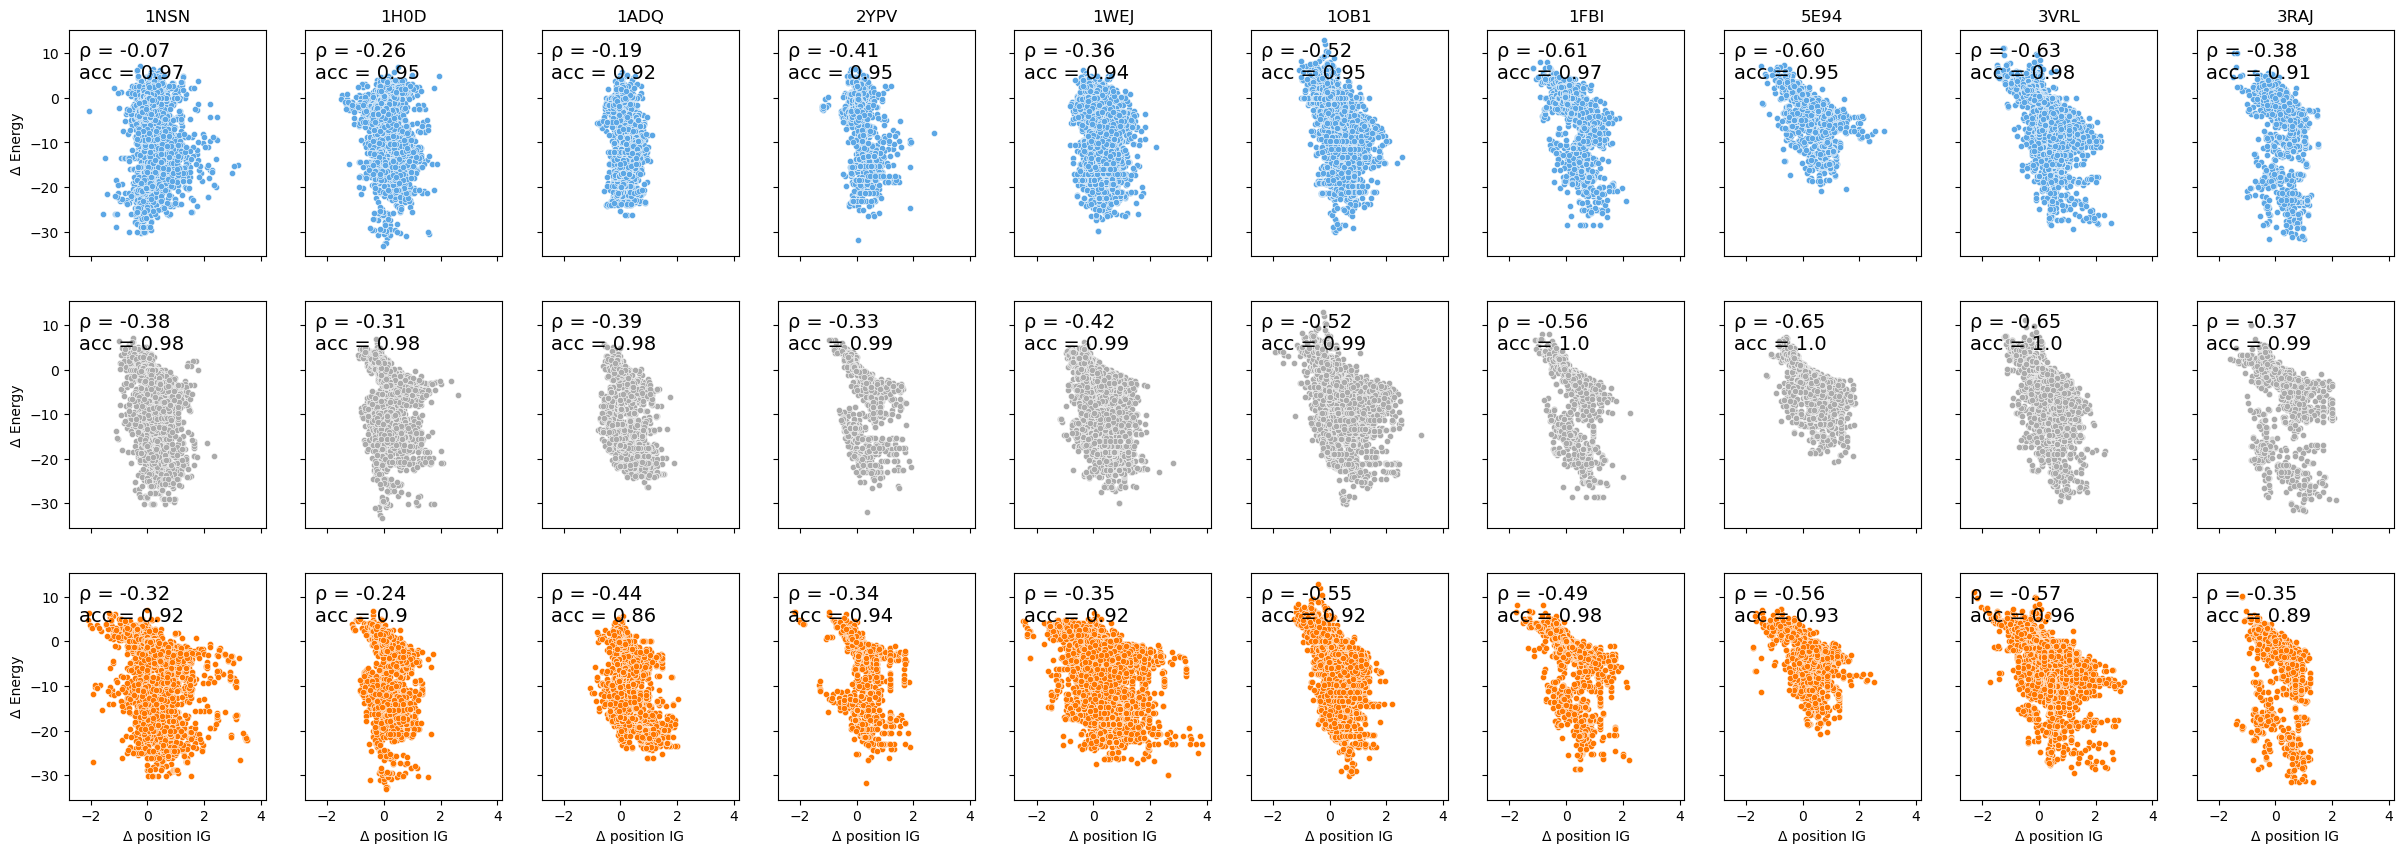

In [198]:
fig, ax = plt.subplots(3,10, figsize=(30,10), sharex=True, sharey=True)
for j, ag in enumerate(order_dict.keys()):
    for i, task in enumerate(tasks):
        mut_ig = pd.read_csv(f'./mutant_igs/{ag}_{task}_mut_igs.csv')
        color = get_color(task)
        sns.scatterplot(mut_ig, x = 'posn delta IG', y='dEnergy', s=20, color=color, ax=ax[i,j])#hue='degree wt'
        acc = perf_df[(perf_df['train_ag'] == ag) & (perf_df['train_task'] == task) & (perf_df['test_task'] == task)]['acc'].max()
        acc = round(acc,2)
       #insert text to each sublot
        ax[i,j].text(0.05, 0.95, 'ρ = {:.2f}\nacc = {acc}'.format(np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1], acc=acc), transform=ax[i,j].transAxes, fontsize=14, verticalalignment='top')
        ax[i,0].set_ylabel(f'{task}\n\n dEnergy')
        #rename x-axis
        ax[2,j].set_xlabel('Δ position IG')
        #rename y-axis
        ax[i,0].set_ylabel('Δ Energy')
    ax[0,j].set_title(ag)


In [200]:
for ag in config.ANTIGENS:
    print(ag)
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
    mut_file = prep_mut_df(ag)
    slide_id_df = get_org_slide_id(mut_file, wt_path)
    #getting aa degrees
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    slide_id_df.drop('seqABParatope', axis=1, inplace=True)
    slide_id_df.to_csv(f'../data/mutated_t6/wt_slide_id/{ag}_slide_id_df.csv')

3VRL
1NSN
3RAJ
5E94
1H0D
1WEJ
1ADQ
1FBI
2YPV
1OB1


In [254]:
# for 1 vs 1
for pos_ag in config.ANTIGENS:
    seed_id = 0
    split_id = 0
    neg_ags = [x for x in config.ANTIGENS if x != pos_ag]
    for neg_ag in neg_ags:
        wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{pos_ag}__vs__{neg_ag}/*_test_dataset.tsv')[0] #this part with for loop is repeated a often, probably I just should store these dfs
        mut_file = prep_mut_df(ag)
        slide_id_df = get_org_slide_id(mut_file, wt_path)
        #getting aa degrees
        path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
        para_epi = pd.read_csv(path_epi, sep='\t')
        slide_id_df= slide_id_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
        slide_id_df['aa_degrees'] = slide_id_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
        slide_id_df.drop('seqABParatope', axis=1, inplace=True)

    ag_vs_one_paths = glob.glob(f"./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_{seed_id}/split_{split_id}/{ag}__vs__*")
    for ag_vs_one_path in ag_vs_one_paths:  
        name = ag_vs_one_path.split('/')[-1]                  
        model_path = f"{ag_vs_one_path}/swa_model/data/model.pth"
        print( model_path)
        #
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        mut_igs = mutant_ig(ig,mut_file, slide_id_df)
        mut_igs.to_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv', index=False)


./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1NSN/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1H0D/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1WEJ/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__3RAJ/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__5E94/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__2YPV/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1FBI/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1OB1/swa_model/data/model.pth
./torch_models/Frozen_MiniAbsolut_ML/1v1/seed_0/split_0/3VRL__vs__1ADQ/swa_model/data/model.pth


TypeError: 'float' object is not subscriptable

In [256]:
slide_id_df

,Slide,ID,Energy,seqABParatope
0,CARHGLGYFWY,16560930_04a,-78.99,NaN
1,GLLRWVLYFDY,11807972_05a,-92.69,NaN


In [246]:
n_mut = 1   
for slide, ID, Energy, degrees in  slide_id_df.values:
    mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
    df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
    print(df_search)
    break
"""        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]"""

                  ID_slide_Variant              CDR3   Best        Slide  \
1         SHH12015154_00a_1m_1_00a       ALQLRLRFAYW   True  ALQLRLRFAYW   
2         SHH12015154_00a_1m_2_00a       CAQLRLRFAYW   True  CAQLRLRFAYW   
3         SHH12015154_00a_1m_3_00a       CCQLRLRFAYW   True  CCQLRLRFAYW   
4         SHH12015154_00a_1m_4_00a       CEQLRLRFAYW   True  CEQLRLRFAYW   
5         SHH12015154_00a_1m_5_00a       CFQLRLRFAYW   True  CFQLRLRFAYW   
...                            ...               ...    ...          ...   
2305338  H_H13948685_04a_1m_14_01a  CARGIPLLEGWYFDVW  False  ARGIPLLEGWY   
2305339  H_H13948685_04a_1m_14_02a  CARGIPLLEGWYFDVW  False  RGIPLLEGWYF   
2305340  H_H13948685_04a_1m_14_03a  CARGIPLLEGWYFDVW  False  GIPLLEGWYFD   
2305341  H_H13948685_04a_1m_14_04a  CARGIPLLEGWYFDVW   True  IPLLEGWYFDV   
2305342  H_H13948685_04a_1m_14_05a  CARGIPLLEGWYFDVW  False  PLLEGWYFDVW   

         Energy          Structure  n_mut            ID  
1        -91.63  145505-RRUDL

"        df_search['original Slide'] = slide\n        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()\n        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]\n        df_search['Energy org'] = [Energy]*df_search.shape[0]"

In [ ]:
#plotting correlations between ig and energy
corr_ig_eng_1v1 = []
for pos_ag in config.ANTIGENS:
    for neg_ag in config.ANTIGENS:
        if pos_ag == neg_ag:
            ig_energy_corr = float()
        else:
            mut_igs = pd.read_csv(f'./mutant_igs/{pos_ag}__vs__{neg_ag}_mut_igs.csv')
             
            ig_energy_corr = np.corrcoef(mut_ig['posn delta IG'].values, mut_ig['dEnergy'].values)[0,1]
            corr_ig_eng_1v1.append([pos_ag, neg_ag, ig_energy_corr])

In [ ]:
corr_ig_eng_1v1_df = pd.DataFrame(corr_ig_eng_1v1, columns=['pos_ag', 'neg_ag', 'ig_energy_corr']).pivot('pos_ag', 'neg_ag', 'ig_energy_corr')

In [ ]:
corr_ig_eng_1v1_df 

neg_ag,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
pos_ag,,,,,,,,,,
1ADQ,NaN,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485
1FBI,-0.353485,NaN,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485
1H0D,-0.353485,-0.353485,NaN,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485
1NSN,-0.353485,-0.353485,-0.353485,NaN,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485
1OB1,-0.353485,-0.353485,-0.353485,-0.353485,NaN,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485
1WEJ,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,NaN,-0.353485,-0.353485,-0.353485,-0.353485
2YPV,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,NaN,-0.353485,-0.353485,-0.353485
3RAJ,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,NaN,-0.353485,-0.353485
3VRL,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,-0.353485,NaN,-0.353485


<AxesSubplot:xlabel='neg_ag', ylabel='pos_ag'>

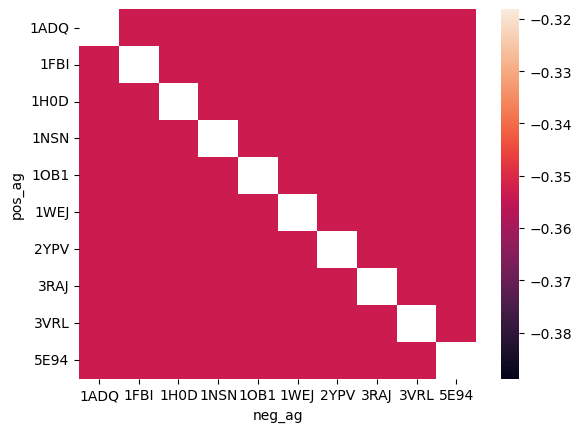

In [ ]:
sns.heatmap(corr_ig_eng_1v1_df)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID,original Slide,IG org,Energy org,mut OH,IG mut,degree wt,posn IG mut,posn IG org,posn delta IG,dEnergy
0,SHH12855434_05a_1m_34_07a,CARVELPAVLLRLWAFAYW,True,AVLLRLWAFAY,-98.42,149471-DUDLULLRLR,1.0,12855434_05a,MVLLRLWAFAY,"[-0.045306993013161226, -0.2234415003959469, 0...",-101.06,"[[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0...","[-0.1187447521740114, -0.2330671460055126, 0.3...",3,-0.118745,-0.045307,0.073438,-2.64
1,SHH12855434_05a_1m_35_07a,CARVELPDVLLRLWAFAYW,False,DVLLRLWAFAY,-90.07,141279-UDDLULLRLU,1.0,12855434_05a,MVLLRLWAFAY,"[-0.045306993013161226, -0.2234415003959469, 0...",-101.06,"[[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...","[-0.5572756870658175, -0.3222849343406144, 0.5...",3,-0.557276,-0.045307,0.511969,-10.99
2,SHH12855434_05a_1m_35_07b,CARVELPDVLLRLWAFAYW,False,DVLLRLWAFAY,-90.07,145439-RLDLULLRLU,1.0,12855434_05a,MVLLRLWAFAY,"[-0.045306993013161226, -0.2234415003959469, 0...",-101.06,"[[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0...","[-0.5572756870658175, -0.3222849343406144, 0.5...",3,-0.557276,-0.045307,0.511969,-10.99
3,SHH12855434_05a_1m_36_07a,CARVELPEVLLRLWAFAYW,False,EVLLRLWAFAY,-90.07,141279-UDDLULLRLU,1.0,12855434_05a,MVLLRLWAFAY,"[-0.045306993013161226, -0.2234415003959469, 0...",-101.06,"[[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0...","[-0.9755703520842005, -0.4067096629829685, 0.6...",3,-0.975570,-0.045307,0.930263,-10.99
4,SHH12855434_05a_1m_37_07a,CARVELPFVLLRLWAFAYW,False,FVLLRLWAFAY,-103.56,149536-DUDDRDLRDU,1.0,12855434_05a,MVLLRLWAFAY,"[-0.045306993013161226, -0.2234415003959469, 0...",-101.06,"[[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0...","[0.28850797022116303, -0.1864459594603446, 0.1...",3,0.288508,-0.045307,-0.333815,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,H_H15367662_00a_1m_72_00a,CAIGWLPLFARW,True,CAIGWLPLFAR,-88.66,149471-LRDUDDRDLL,1.0,15367662_00a,CAIGWLPLFAY,"[0.002293195920800598, 0.0075083574719842835, ...",-98.37,"[[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...","[0.003196139950990275, 0.00878367945644675, 0....",3,-0.751476,-0.163732,0.587744,-9.71
5015,H_H15367662_00a_1m_73_00a,CAIGWLPLFASW,True,CAIGWLPLFAS,-88.66,149471-LRDUDDRDLL,1.0,15367662_00a,CAIGWLPLFAY,"[0.002293195920800598, 0.0075083574719842835, ...",-98.37,"[[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...","[0.0179822621130378, 0.021170863062735558, 0.5...",3,-0.652397,-0.163732,0.488665,-9.71
5016,H_H15367662_00a_1m_74_00a,CAIGWLPLFATW,True,CAIGWLPLFAT,-95.00,153631-DUDUDDRDLR,1.0,15367662_00a,CAIGWLPLFAY,"[0.002293195920800598, 0.0075083574719842835, ...",-98.37,"[[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...","[0.1842597019574218, 0.2542322641950314, 0.385...",3,-0.402914,-0.163732,0.239181,-3.37
5017,H_H15367662_00a_1m_75_00a,CAIGWLPLFAVW,True,CAIGWLPLFAV,-100.15,153631-DUDUDDRDLR,1.0,15367662_00a,CAIGWLPLFAY,"[0.002293195920800598, 0.0075083574719842835, ...",-98.37,"[[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0...","[0.002093895517244695, 0.005592850664884951, 0...",3,-0.046584,-0.163732,-0.117148,1.78


## Calculating IG for all test sequences

In [42]:
for ag in config.ANTIGENS:
    wt_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/{ag}__vs__9/*_test_dataset.tsv')[0]
    wt_df = pd.read_csv(wt_path, sep='\t')
    binder_df = wt_df[wt_df['y'] == 1]
    binder_df['X'] = binder_df.Slide.apply(onehot_encode)
    # get degree of each slide
    path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
    para_epi = pd.read_csv(path_epi, sep='\t')
    binder_df= binder_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
    binder_df['aa_degrees'] = binder_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
    binder_df['degrees'] = binder_df['aa_degrees'].apply(lambda d: list(map(lambda x: int(re.search('(\d)',x).group(1)),d)))
    binder_df.drop('seqABParatope', axis=1, inplace=True)

    for task in tasks:
        seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        ig = IntegratedGradients(model.cpu())
        binder_df['IG'] = binder_df.X.apply(lambda x: ig_from_oh(x,ig,baseline))
        binder_df.to_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv', index=False)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/210821106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binder_df['X'] = binder_df.Slide.apply(onehot_encode)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


KeyboardInterrupt: 

In [43]:
task = 'ONE_VS_NINE'
order_dict = dict()
for ag in config.ANTIGENS:
    ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
    ig_df['IG'] = ig_df['IG'].apply(eval)
    ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
    igs = np.concatenate(ig_df['IG'].values).astype(float)
    degrees = np.concatenate(ig_df['degrees'].values).astype(int)
    df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})
    order_dict[ag] = np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]

In [44]:
order_dict
order_dict = {k: v for k, v in sorted(order_dict.items(), key=lambda item: item[1])}

In [45]:
order_dict

{'1NSN': -0.4423994789235985,
 '1H0D': -0.28370929649712934,
 '1ADQ': -0.0032288779708532053,
 '2YPV': 0.032518100719305006,
 '1WEJ': 0.1257234742535492,
 '1OB1': 0.19204966473114404,
 '1FBI': 0.2765363323910073,
 '5E94': 0.46500462982794616,
 '3VRL': 0.48316998231615477,
 '3RAJ': 0.5679816212601967}

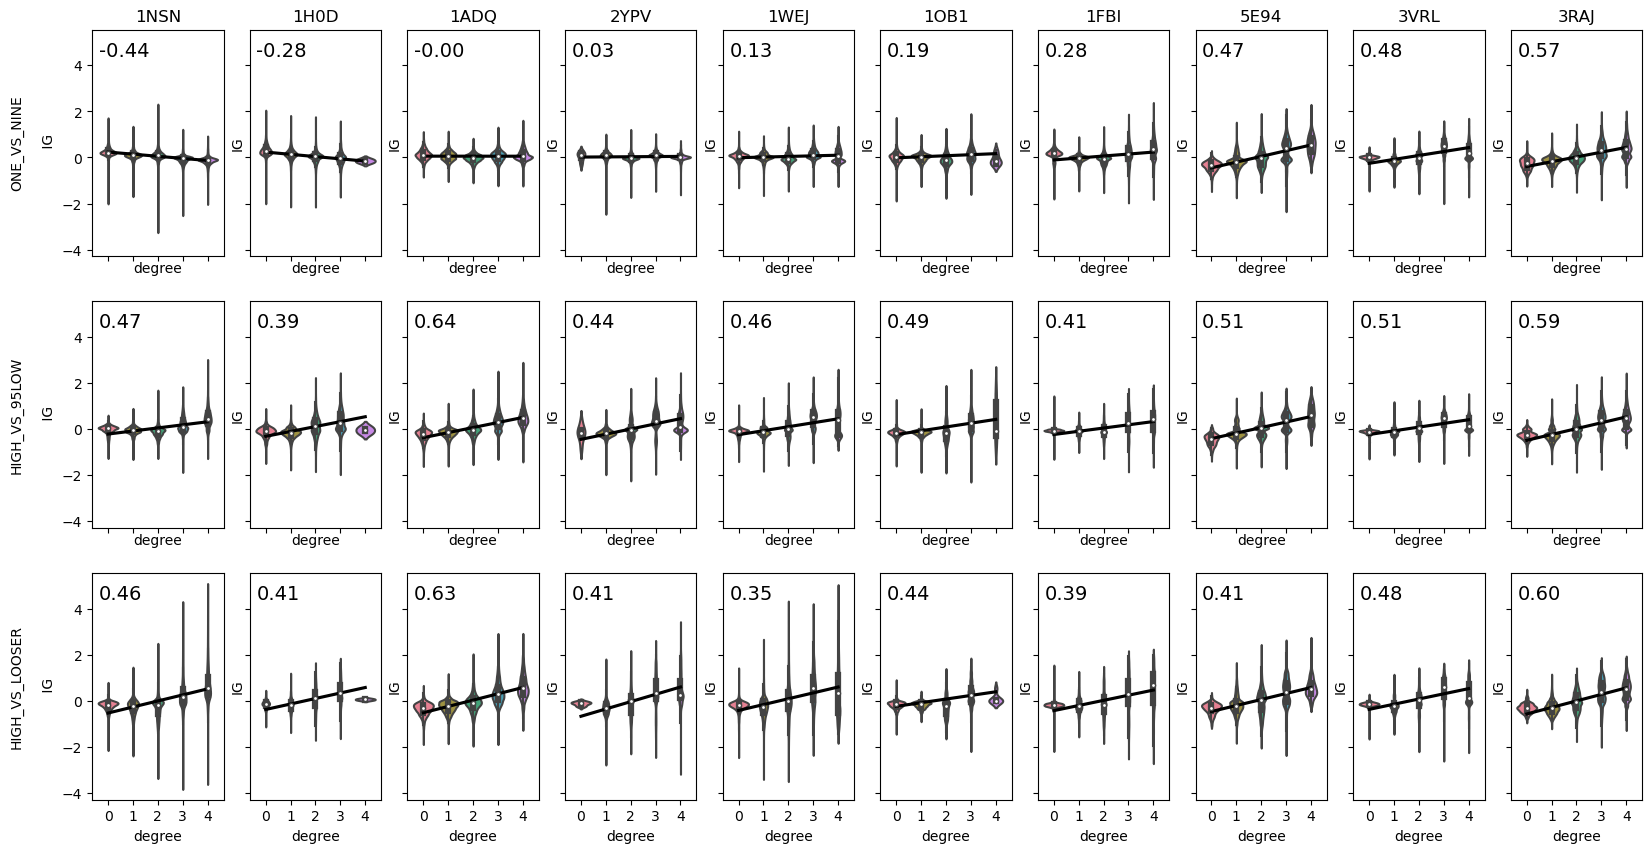

In [46]:
fig, ax = plt.subplots(3,10, sharex=True, sharey=True, figsize=(20,10))
for i, task in enumerate(tasks):
    for j, ag in enumerate(order_dict.keys()):
        #converters = {'IG': pd.eval, 'degrees': pd.eval}
        ig_df = pd.read_csv(f'./binder_igs/{ag}_{task}_binder_igs.csv')
        ig_df['IG'] = ig_df['IG'].apply(eval)
        ig_df['degrees'] = ig_df['degrees'].apply(eval)
        # create df with ig and degree correspondance 
        igs = np.concatenate(ig_df['IG'].values).astype(float)
        degrees = np.concatenate(ig_df['degrees'].values).astype(int)
        df_degree_ig = pd.DataFrame.from_dict({'degree': degrees, 'IG': igs})

        r = i
        c = j
        sns.violinplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], palette='husl')
        sns.regplot(df_degree_ig,x='degree', y='IG', ax=ax[r,c], scatter=False, color='black')
        ax[r,c].text(0.05, 0.95, '{:.2f}'.format(np.corrcoef(df_degree_ig['degree'].values, df_degree_ig['IG'].values)[0,1]), transform=ax[r,c].transAxes, fontsize=14, verticalalignment='top')
        #title of sublots
        ax[0,c].set_title(ag)
    ax[r,0].set_ylabel(f'{task}\n\n IG')


In [84]:
seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')
train_data_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/*_train_dataset.tsv')[0]
train_df = pd.read_csv(train_data_path, sep='\t')
path_epi = glob.glob(f'../data/Slide_importance/{ag}_[A-Z]_Task4_Slice_ParaEpi.txt')[0]
para_epi = pd.read_csv(path_epi, sep='\t')
train_df= train_df.merge(para_epi[['Slide', 'seqABParatope']], on=['Slide'], how='left')
train_df['aa_degrees'] = train_df.apply(lambda x: full_slide_degree(x.Slide, x.seqABParatope), axis=1)
train_df.drop('seqABParatope', axis=1, inplace=True)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_24208/2755369327.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


TypeError: 'float' object is not subscriptable

In [82]:
#loose
pd.read_csv(train_data_path, sep='\t').head()

,Slide,binds_a_pos_ag,Slide_onehot,X,y
0,AAAVLLRYLYY,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AAFITTVVARF,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
2,AAFYGNLAWFA,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AAFYYDYPAWF,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,AAGLLLAWFAY,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1


## Old  code need refactoring

In [80]:
def get_2mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(10):
        for j in range(i+1,11):
            mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]'] + ex_slide_list[i+1:j] + [f'[^{ex_slide_list[j]}]']
            if j < 10:
                mut_pattern = mut_pattern + ex_slide_list[j+1:]  
            mut_patterns.append(((i,j),''.join(mut_pattern)))
    return mut_patterns

In [81]:
def mutant2_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_2mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for (i, j), pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut1'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG mut2'] = df_pos_mut['IG mut'].apply(lambda x: x[j])
            df_pos_mut['posn IG org1'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn IG org2'] = df_pos_mut['IG org'].apply(lambda x: x[j])
            df_pos_mut['posn1 delta IG'] =  df_pos_mut['posn IG org1'] - df_pos_mut['posn IG mut1']
            df_pos_mut['posn2 delta IG'] =  df_pos_mut['posn IG org2'] - df_pos_mut['posn IG mut2']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

In [82]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1NSN_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_igs = mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut=2)

In [83]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1ADQ_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_igs = mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [84]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_loos_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [85]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_loos_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [86]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_low_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [87]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_low_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [88]:
mut_1nsn_igs.columns

Index(['ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy', 'Structure',
       'n_mut', 'ID', 'original Slide', 'IG org', 'Energy org', 'mut OH',
       'IG mut', 'posn IG mut', 'posn IG org', 'posn delta IG', 'dEnergy'],
      dtype='object')

In [94]:
def get_3D_2mut_plot(df, pic_name):
    color = get_color(pic_name)
    for i, (a1, a2) in enumerate([(180,20),(90,0),(180,0)]): #(180,30),(90,30) #(45,90),(0,0), (90,0)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['posn1 delta IG'], df['posn2 delta IG'], df['dEnergy'], color=color, alpha=1, s=5)
        ax.set_zlabel('Δ Energy')
        if i <= 1:
            ax.set_xlabel('Δ p1 IG')
        else:
            ax.set_xlabel('')
        if i !=1:
            ax.set_ylabel('Δ p2 IG')
        else:
            ax.set_ylabel('')
        # rotate the axes and update
        ax.view_init(a2, a1)
        fig.tight_layout() #reg_coef[], reg_coef
        plt.savefig(f'./plots/{pic_name}_3D_{a2}_{a1}.png', bbox_inches = 'tight')
        plt.show()


In [95]:
#low color = '#1f78b4'
#1 vs all color = '#a6cee3'
#loose color='#b2df8a'

In [96]:
print(get_corr(mut2_1adq_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.31
-0.31


In [97]:
reg = LinearRegression()
X = mut2_1adq_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.17339576 -12.23119589]


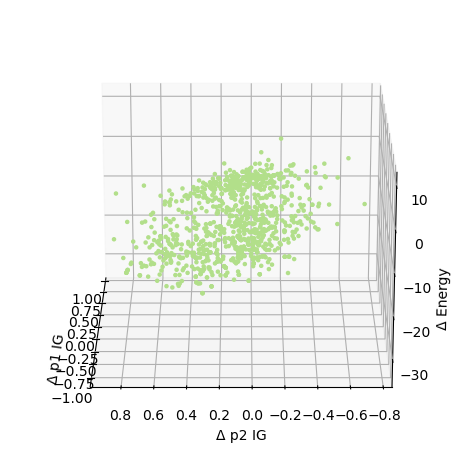

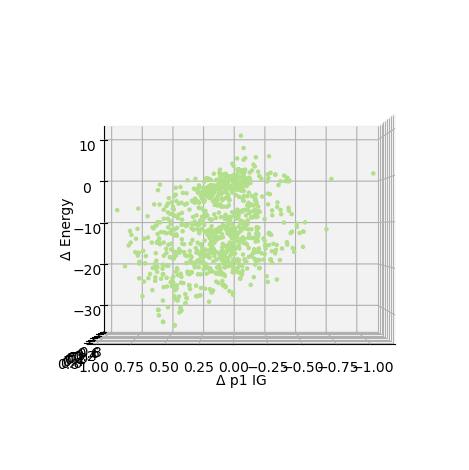

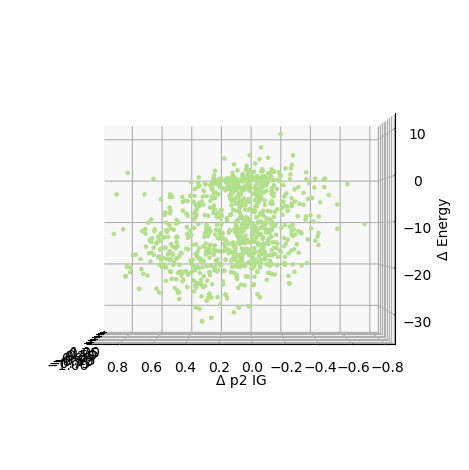

In [98]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_loos_igs, 'mut2_1adq_loos_igs' )

In [99]:
print(get_corr(mut2_1nsn_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.28
-0.26


In [100]:
reg = LinearRegression()
X = mut2_1nsn_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-13.16979714 -14.92426165]


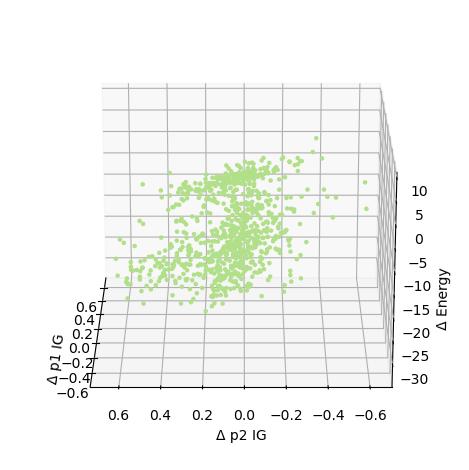

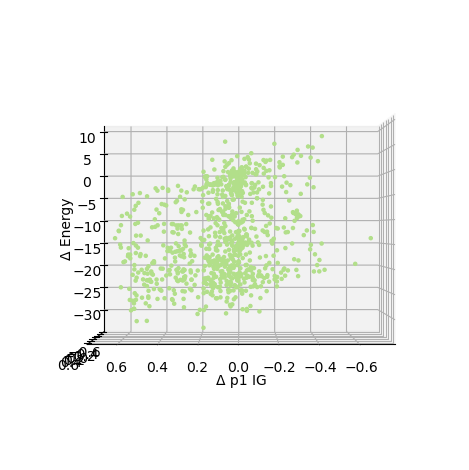

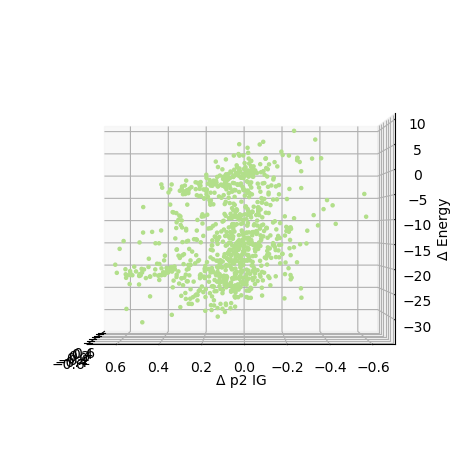

In [101]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_loos_igs, 'mut2_1nsn_loos_igs')

In [102]:
print(get_corr(mut2_1adq_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_low_igs,['posn2 delta IG', 'dEnergy']))

-0.29
-0.32


In [103]:
reg = LinearRegression()
X = mut2_1adq_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[ -8.5201599  -10.00256347]


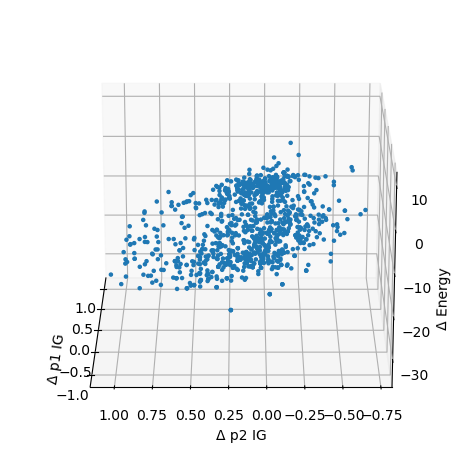

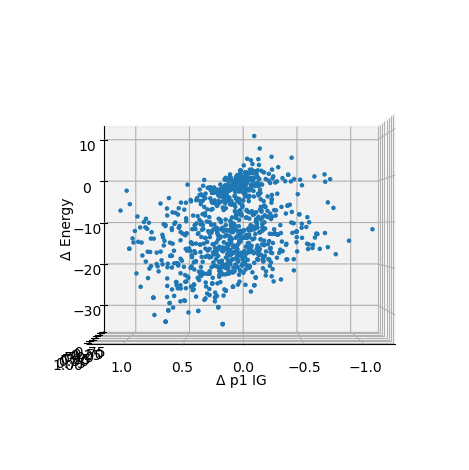

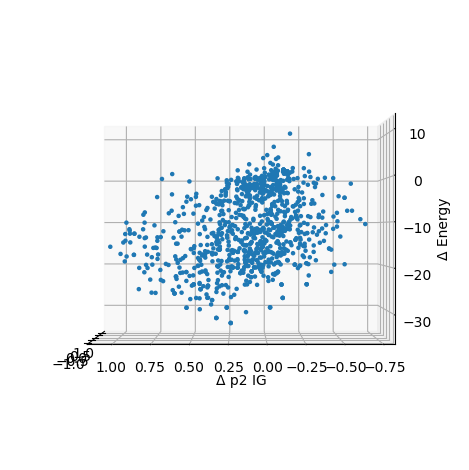

In [104]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_low_igs, 'mut2_1adq_low_igs')

In [105]:
print(get_corr(mut2_1nsn_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_low_igs,['posn2 delta IG', 'dEnergy']))

-0.32
-0.29


In [106]:
reg = LinearRegression()
X = mut2_1nsn_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.26568641 -13.2598453 ]


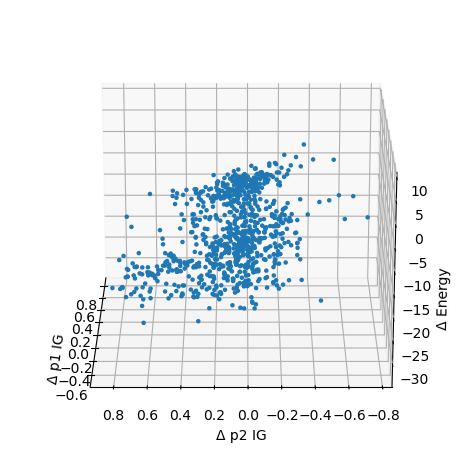

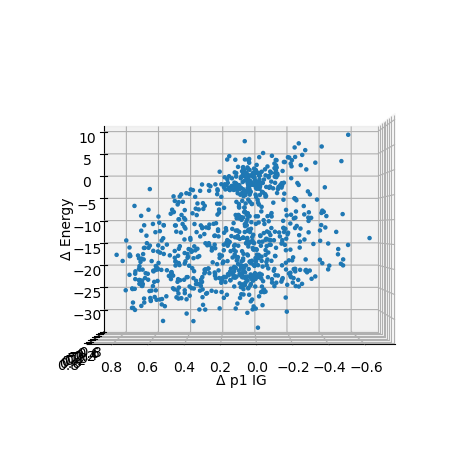

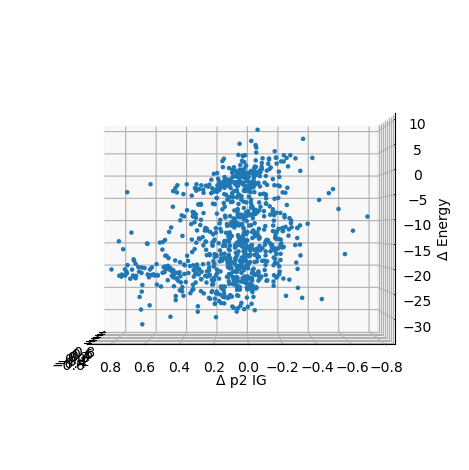

In [107]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_low_igs, 'mut2_1nsn_low_igs')

In [108]:
print(get_corr(mut2_1adq_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_igs,['posn2 delta IG', 'dEnergy']))

-0.05
0.03


In [109]:
reg = LinearRegression()
X = mut2_1adq_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-2.50672844  1.07278183]


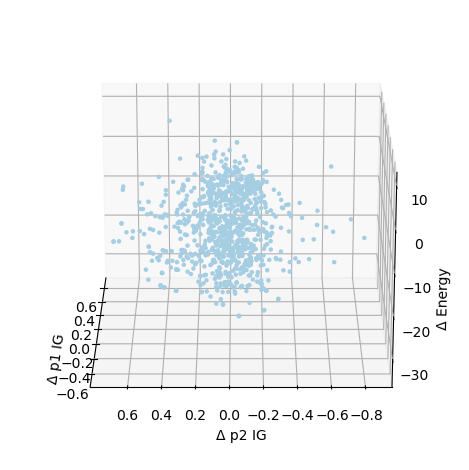

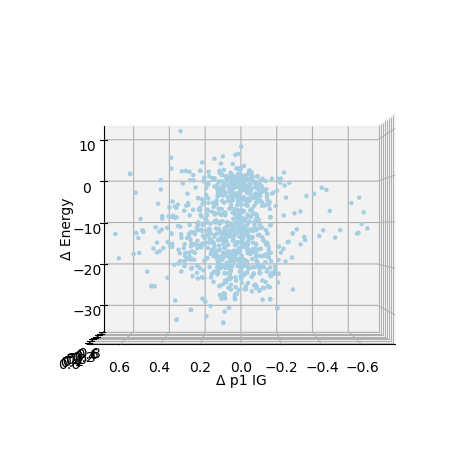

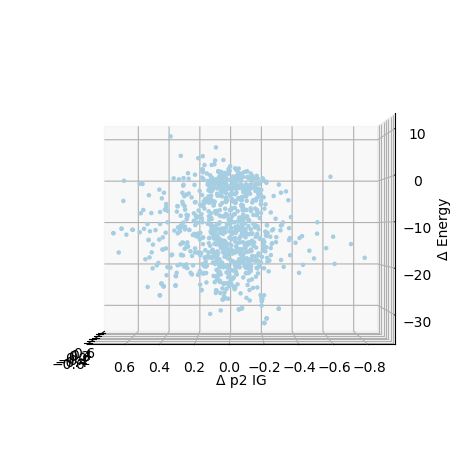

In [110]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_igs, 'mut2_1adq_igs')

In [111]:
print(get_corr(mut2_1nsn_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_igs,['posn2 delta IG', 'dEnergy']))

0.02
0.05


In [112]:
reg = LinearRegression()
X = mut2_1nsn_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[0.81135656 1.76760016]


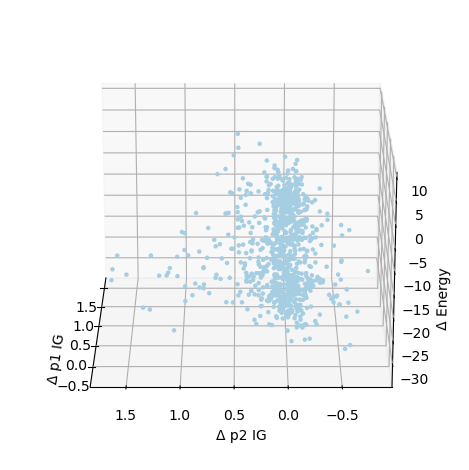

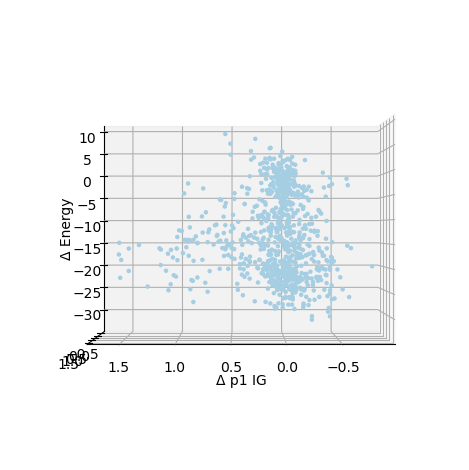

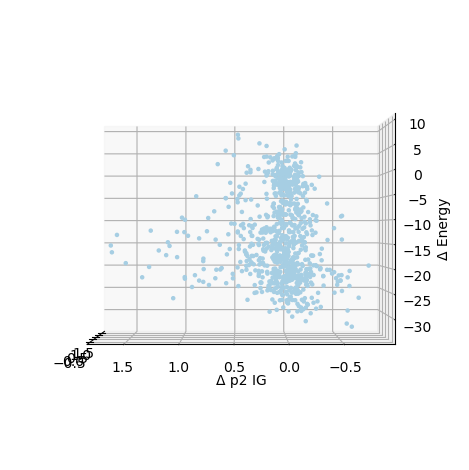

In [113]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_igs, 'mut2_1nsn_igs')